# Hospital Readmissions Data Analysis and Recommendations for Reduction

### Background
In October 2012, the US government's Center for Medicare and Medicaid Services (CMS) began reducing Medicare payments for Inpatient Prospective Payment System hospitals with excess readmissions. Excess readmissions are measured by a ratio, by dividing a hospital’s number of “predicted” 30-day readmissions for heart attack, heart failure, and pneumonia by the number that would be “expected,” based on an average hospital with similar patients. A ratio greater than 1 indicates excess readmissions.

### Exercise Directions

In this exercise, you will:
+ critique a preliminary analysis of readmissions data and recommendations (provided below) for reducing the readmissions rate
+ construct a statistically sound analysis and make recommendations of your own 

More instructions provided below. Include your work **in this notebook and submit to your Github account**. 

### Resources
+ Data source: https://data.medicare.gov/Hospital-Compare/Hospital-Readmission-Reduction/9n3s-kdb3
+ More information: http://www.cms.gov/Medicare/medicare-fee-for-service-payment/acuteinpatientPPS/readmissions-reduction-program.html
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import scipy
import scipy.stats as stats
#import bokeh.plotting as bkp
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# read in readmissions data provided
hospital_read_df = pd.read_csv('data/cms_hospital_readmissions.csv')
gi = pd.read_csv('data/Hospital_General_Information.csv')
spending = pd.read_csv('data/Medicare_hospital_spending_per_patient__Medicare_Spending_per_Beneficiary____Additional_Decimal_Places.csv')


In [3]:
# very little overlap in hospitals among these lists 
# (~ 90 of those in 'spending' and 'gi' are also found in hospital_read_df)

#len(gi), len(hospital_read_df), len(spending)
#pn = hospital_read_df['Provider Number']
#gi_pn = gi['Provider ID']
#sp_pn = spending['Provider_ID']

****
## Preliminary Analysis

In [4]:
# deal with missing and inconvenient portions of data 
clean_hospital_read_df = hospital_read_df[hospital_read_df['Number of Discharges'] != 'Not Available']
clean_hospital_read_df.loc[:, 'Number of Discharges'] = clean_hospital_read_df['Number of Discharges'].astype(int)
clean_hospital_read_df = clean_hospital_read_df.sort_values('Number of Discharges')

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


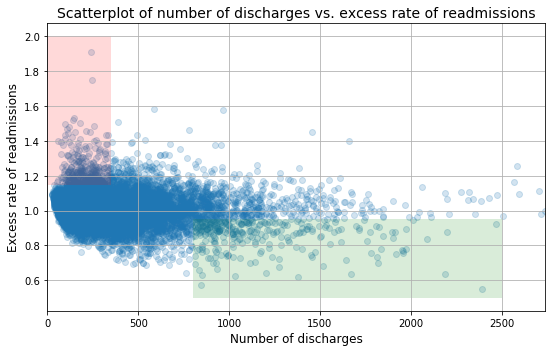

In [5]:
# generate a scatterplot for number of discharges vs. excess rate of readmissions
# lists work better with matplotlib scatterplot function
x = [a for a in clean_hospital_read_df['Number of Discharges'][81:-3]]
y = list(clean_hospital_read_df['Excess Readmission Ratio'][81:-3])

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)

ax.fill_between([0,350], 1.15, 2, facecolor='red', alpha = .15, interpolate=True)
ax.fill_between([800,2500], .5, .95, facecolor='green', alpha = .15, interpolate=True)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Excess rate of readmissions', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. excess rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()

****

## Preliminary Report

Read the following results/report. While you are reading it, think about if the conclusions are correct, incorrect, misleading or unfounded. Think about what you would change or what additional analyses you would perform.

**A. Initial observations based on the plot above**
+ Overall, rate of readmissions is trending down with increasing number of discharges
+ With lower number of discharges, there is a greater incidence of excess rate of readmissions (area shaded red)
+ With higher number of discharges, there is a greater incidence of lower rates of readmissions (area shaded green) 

**B. Statistics**
+ In hospitals/facilities with number of discharges < 100, mean excess readmission rate is 1.023 and 63% have excess readmission rate greater than 1 
+ In hospitals/facilities with number of discharges > 1000, mean excess readmission rate is 0.978 and 44% have excess readmission rate greater than 1 

**C. Conclusions**
+ There is a significant correlation between hospital capacity (number of discharges) and readmission rates. 
+ Smaller hospitals/facilities may be lacking necessary resources to ensure quality care and prevent complications that lead to readmissions.

**D. Regulatory policy recommendations**
+ Hospitals/facilties with small capacity (< 300) should be required to demonstrate upgraded resource allocation for quality care to continue operation.
+ Directives and incentives should be provided for consolidation of hospitals and facilities to have a smaller number of them with higher capacity and number of discharges.

****
****

<div  style="background-color:PapayaWhip"> <b> Hospital Readmission - preparing some plots</b> .. skip over this</div>

In [6]:
# making a copy of the data and dropping columns I won't be using.  Also renaming
# some columns just to make them easier to type and work with
cdf = clean_hospital_read_df.copy()
cdf.drop('Hospital Name', axis=1, inplace=True)
cdf.drop('State', axis=1, inplace=True)
cdf.drop('Measure Name', axis=1, inplace=True)
cdf.drop('Footnote', axis=1, inplace=True)

cdf.dropna(subset=['Number of Readmissions'], inplace=True)
cdf.rename(columns={'Number of Discharges':'discharges', \
                    'Excess Readmission Ratio':'excess_ratio', \
                   'Predicted Readmission Rate':'predicted_rate', \
                    'Expected Readmission Rate':'expected_rate',\
                   'Number of Readmissions':'readmissions'}, inplace=True)



# a simple ratio of readmissions over discharges.
cdf['readmit_rate'] = cdf.readmissions/cdf.discharges


# wanted to look at raw values first before getting into questions of 'expected', 
# 'predicted', 'excess', etc.  
def fig1():
    print "Elite hospitals mean readmission rate     = ", \
     round(cdf[(cdf.readmit_rate <= .1) & (cdf.discharges < 3000)].readmit_rate.mean(), 3)
    print "Non-elite hospitals mean readmission rate = ", \
    round(cdf[(cdf.readmit_rate > .1) & (cdf.discharges < 3000)].readmit_rate.mean(), 3)
    
    fig, axs = plt.subplots(1, 2, figsize=(18,4))
    axs[0].scatter(cdf.discharges, cdf.readmissions ,alpha=0.2);
    axs[0].set_xlabel('Number of discharges')
    axs[0].set_ylabel('Readmissions')
    cdf[['readmit_rate', 'discharges', 'readmissions']]\
              .sort_values('discharges').readmit_rate\
                 .plot(kind='hist', bins=200, ax=axs[1], \
                   title='readmissions/discharges (readmit_rate)')
    
def fig1a():
    elitemean = round(cdf[(cdf.readmit_rate < .1) & (cdf.discharges < 3000)]\
                                                      .discharges.mean(), 2) 
    print 'average size of elite hospitals              (red dotted) = ', elitemean,\
                                                                   'discharges'
    
    non_elitemean = round(cdf[(cdf.readmit_rate > .1) & (cdf.discharges < 3000)]\
                                                          .discharges.mean(), 2)
    print 'average size of non-elite hospitals       (orange dotted) = ', non_elitemean,\
                                                                       'discharges'
        
    deathtrapmean = round(cdf[(cdf.readmit_rate > .3)].discharges.mean(), 2)
    print 'average size of worst performing hospitals (black dotted) = ', deathtrapmean,\
                                                                       'discharges'
       
    fix, axs = plt.subplots(1, 2, figsize=(20, 6))
    dischargeline = cdf[cdf.discharges < 3000]
    axs[0].scatter(dischargeline.discharges, dischargeline.readmit_rate)
    axs[0].set_xlabel('Number of discharges')
    axs[0].set_ylabel('Readmission rate')
    axs[0].set_title("All hospitals")
    axs[0].axhline(.05, color='r', linewidth=62, alpha=.3)
    axs[0].axhline(.2, color='orange', linewidth=124, alpha=.3)
    axs[0].vlines(x=elitemean, ymin=0, ymax=.1, color='red',\
                                       linestyle='dotted', linewidth=4)
    axs[0].vlines(x=non_elitemean, color='orange', linestyle='dotted', \
                                       linewidth=4, ymin=.1, ymax=.3)
    axs[0].vlines(x=deathtrapmean, color='black', linestyle='dotted', \
                                       linewidth=4, ymin=.3, ymax=.5)
    axs[0].axvline(300, color='white', linewidth=1)
    
    cdf[(cdf.readmit_rate < .1) & (cdf.discharges < 3000)]\
        .discharges.plot(ax=axs[1], kind='hist',bins=100, color='brown', alpha=.9)
        
    cdf[(cdf.readmit_rate > .1) & (cdf.discharges < 3000)]\
        .discharges.plot(ax=axs[1], kind='hist', bins=100, alpha=.6, \
                                       title='discharges on x axis')
    axs[1].axvline(300, color='white', linewidth=1)
    
    small_cohort = cdf[['readmit_rate', 'discharges']][(cdf.discharges < 300)]
    large_cohort = cdf[['readmit_rate', 'discharges']][(cdf.discharges > 300)]
    death_traps = cdf[['readmit_rate', 'discharges']][(cdf.readmit_rate > .3)]

    fig, axs = plt.subplots(1, 3, figsize=(18,4))
    small_cohort[['readmit_rate', 'discharges']].sort_values('discharges').readmit_rate\
        .plot(kind='hist', bins=200, ax=axs[0], title='small hospitals (readmit_rate)')
    large_cohort[['readmit_rate', 'discharges']].sort_values('discharges').readmit_rate\
        .plot(kind='hist', bins=200, ax=axs[1], \
              title='large hospitals (readmit_rate)\n note clearly differentiated bimodal distribution')
    death_traps[['readmit_rate', 'discharges']].sort_values('discharges').readmit_rate\
    .plot(kind='hist', bins=200, ax=axs[2], title='worst perfomers (readmit_rate)');


# the histogram in fig1 shows two clear peaks.  The readmit rate value of .1 is a convenient
# place to separate them.  Discharges > 3000 removes 3 outliers.
def fig2():
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    cdf[(cdf.readmit_rate < .1) & (cdf.discharges < 3000)]\
           .discharges.plot(ax=axs[0], kind='hist',bins=100, color='orange', alpha=.9)
    cdf[(cdf.readmit_rate > .1) & (cdf.discharges < 3000)]\
          .discharges.plot(ax=axs[0], kind='hist', bins=100, alpha=.6, \
    title='discharges on x axis( orange/olive:readmit_rate < .1, blue:readmit_rate > .1 )')
    
    cdf[cdf.discharges < 111].readmit_rate.plot(ax=axs[1], kind='hist', bins=20, \
    title='readmissions/discharges for hospitals with fewer than 111 discharges')
    axs[0].set_yscale('log')
    print '# discharges of hospitals with readmit rate < .1 = ', \
           round(cdf[(cdf.readmit_rate < .1) & (cdf.discharges < 3000)].discharges.mean(), 2)
    print '# discharges of hospitals with readmit rate > .1 = ', \
           round(cdf[(cdf.readmit_rate > .1) & (cdf.discharges < 3000)].discharges.mean(), 2)
    lsb = len(cdf[(cdf.readmit_rate < .1) & (cdf.discharges < 400)])
    lss = len(cdf[(cdf.readmit_rate < .1) & (cdf.discharges > 400)])
    print 'low readmit hospitals with < 400 discharges =', lsb
    print 'low readmit hospitals with > 400 discharges =', lss
    lsb = len(cdf[(cdf.readmit_rate > .1) & (cdf.discharges < 400)])
    lss = len(cdf[(cdf.readmit_rate > .1) & (cdf.discharges > 400)])
    print 'high readmit hospitals with < 400 discharges =', lsb
    print 'high readmit hospitals with > 400 discharges =', lss

def fig_excess_1():
    exline = cdf[cdf.discharges < 3000]
    fig, axs = plt.subplots(1,2,figsize=(18,6))
    axs[0].scatter(exline.readmit_rate, exline.excess_ratio, s=2)
    axs[0].set_ylabel('Excess ratio')
    axs[0].set_xlabel('Readmission rate')
    axs[1].scatter(exline.discharges, exline.excess_ratio, s=2)
    axs[1].set_ylabel('Excess ratio')
    axs[1].set_xlabel('Discharges')
    axs[1].axvline(300)

def fig_excess_2():
    fig, ax = plt.subplots(1,1,figsize=(20, 5))
    cdf.excess_ratio.plot(kind='hist', bins=300, alpha=.3);

    small_h = cdf[(cdf.discharges < 300)]
    small_h['excess_ratio'].plot(kind='hist', bins=300, color='orange', alpha=.6);
    ax.axvline(small_h.excess_ratio.mean(), color='orange', linewidth=2)

    big_h = cdf[(cdf.discharges > 300) & (cdf.discharges < 3000)]
    big_h['excess_ratio'].plot(kind='hist', bins=300, color='green', alpha=.6);
    ax.axvline(big_h.excess_ratio.mean(), color='green', linewidth=2);
    ax.set_title('excess ratio (green:hospitals > 300 discharges | orange:hospitals < 300 discharges)')


# looking for that downward trend that they report. 
def fig3():
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    cdf[['discharges', 'readmit_rate']][cdf.discharges < 3000]\
          .sort_values('discharges', ascending=False)\
          .plot(ax=axs[0], kind='scatter', x='discharges', y='readmit_rate')
            
    cdf[['discharges', 'readmit_rate']][(cdf.discharges < 500)]\
          .sort_values('discharges', ascending=False)\
          .plot(ax=axs[1], kind='scatter', x='discharges', y='readmit_rate')
        
def fig4():
    fig, axs = plt.subplots(1, 2, figsize=(18, 4))
    cdf['scaled_readmit_rate'] = cdf['readmit_rate'] * 100
    cdf['200_readmit_ma'] = cdf.sort_values('expected_rate')\
                     .scaled_readmit_rate.rolling(200).mean()
    cdf['4_readmint_ma'] = cdf.sort_values('expected_rate')\
                      .scaled_readmit_rate.rolling(4).mean()
    cdf.sort_values('expected_rate').reset_index()\
            [['expected_rate', 'scaled_readmit_rate', '200_readmit_ma']]\
                                                   .plot(alpha=.6, ax=axs[0],\
                                                   title='demystifying "expected" rate')
    cdf.sort_values('expected_rate').reset_index()\
        [:100][['predicted_rate', 'scaled_readmit_rate', '4_readmint_ma']]\
                                                    .plot(alpha=.7, ax=axs[1],\
                                                    title='demystifying "predicted" rate')

def fig5():
    fig, axs = plt.subplots(1, 2, figsize=(18, 5))
    cdf[(cdf.excess_ratio < 16) & (cdf.discharges < 3000)].\
           plot(x='excess_ratio', y='discharges', kind='scatter', ax=axs[0], s=1, \
                title='"excess" ratio for all hospitals')
        
    cdf[(cdf.excess_ratio < 16) & (cdf.discharges < 111)].\
           plot(x='excess_ratio', y='discharges', kind='scatter', ax=axs[1], s=1,\
               title='"excess" ratio for the smallest hospitals (below 111 discharges)')


<div  style="background-color:PapayaWhip"> <b> Hospital Readmission - reviewing the data </b></div>

Hospitals were evaluated in terms of their readmission rates in a study that concluded with a recommendation to consolidate smaller hospitals into larger ones unless they meet certain requirements.  

The indicator that is the basis of this recommendation, the "excess rate" of readmissions, is not fully explained.  However, we do know that the "expected" and "predicted" rates, from which the "excess rate" is derived, are based on a notion of a peer group of hospitals that depends on "an average hospital with similar patients".  We will also see that these two values, the "expected" and "predicted" rates, can be understood in terms of the data present in this dataset.

Before considering these benchmarks, however, let's look at the data we're actaully given.  The scatter plot on the left shows the number of readmissions vs the number of discharges and the histogram on the right shows the ratio between those two values, which I'll call the readmit_rate.

There appear to be two classes of hospitals.  Most hospitals belong to a group that gets roughly between 10% and 30% of their discharged patients back, while a smaller number of hospitals have set themselves apart, getting fewer than 10% of their patients back with a mean for that group just under 6%. 

Elite hospitals mean readmission rate     =  0.057
Non-elite hospitals mean readmission rate =  0.2


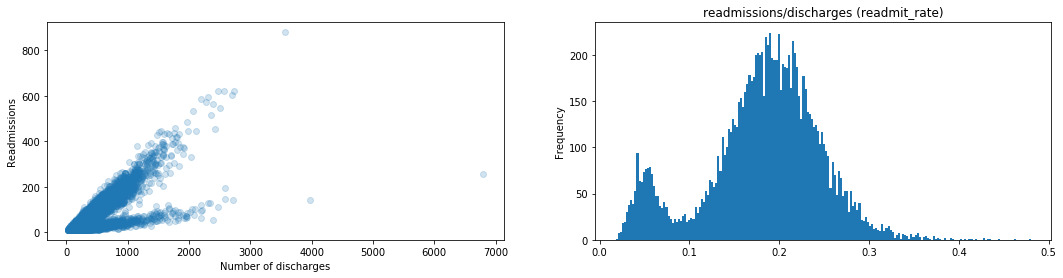

In [7]:
fig1()

The question put on the table by the study conclusions is what role size plays in the difference in readmission rates.  The study conclusions contemplate consolidating hospitals below 300 discharges (solid white vertical line in the plots below) into those above that number.  This is, indeed, the size at which the two classes of outcomes begin to emerge (scatter plot below/left).   

Below the level of 300 discharges in the period, there is also a group of very poorly performing hospitals with greater than a 30% readmission rate.  This is actually a third class of hospital, but they are too few in number to make up their own bump in the histogram above.

Among the larger hospitals (more than 300 discharges), there are almost no hospitals right at the 10% readmission rate.  Something happens at larger hospitals that leads them down one of two paths towards either peak or middle of the road performance.  Whatever those conditions or opportunities may be, they do not appear to be faced by smaller hospitals in the same way.  While there are small hospitals among the elite performers, the rounded corner in the lower left of the scatter plot below suggests that small size is an inhibiting factor.

average size of elite hospitals              (red dotted) =  536.11 discharges
average size of non-elite hospitals       (orange dotted) =  340.96 discharges
average size of worst performing hospitals (black dotted) =  147.97 discharges


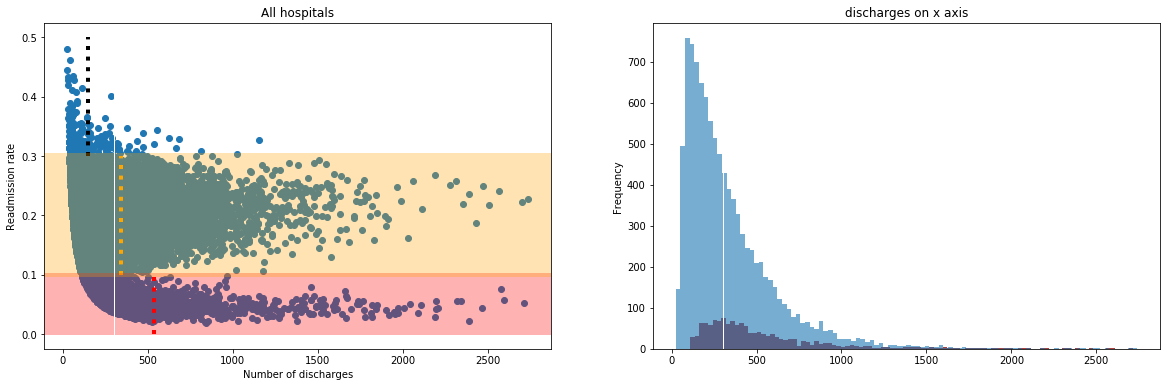

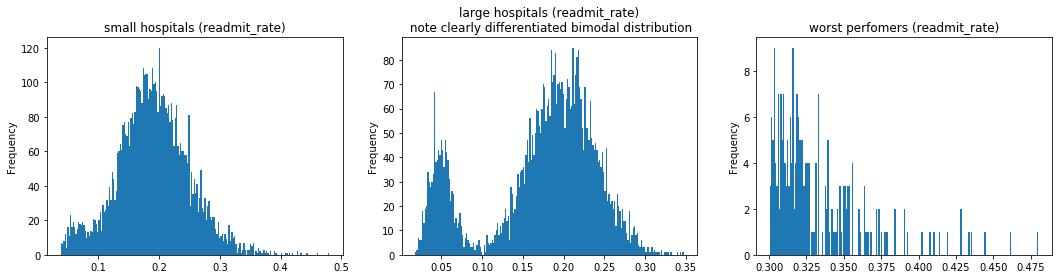

In [8]:
fig1a()

Although the study recommendation is keyed on hospital size, the analysis that led to it is based on an indicator called the "excess readmission ratio".

<blockquote>Excess readmission ratio = (risk-adjusted predicted readmissions) / (risk-adjusted expected readmissions) 
</blockquote>

One thing to note about the "expected" and "predicted" rates from which the "excess" rate is derived is that, although we know only a little about what they are, they can be approximated by the 200 point and 4 point moving averages, respectively, of readmission rate (plots below).  Although that doesn't explain what they are, it gives a context for understanding them.  Again, these numbers are rooted in some notion of a peer group.  What we can see here is that those peer groups align fairly well with the readmission rates.

So, the "expected" and "predicted" rates are both understandable as different degrees of smoothing of the readmission rate, given some method of sorting hospitals by peer group. The excess rate, in turn, is only the ratio between them, so we can view the excess ratio as being the degree of deviation from an ideal, where that ideal is localized to the peer group to which a particular hospital belongs.


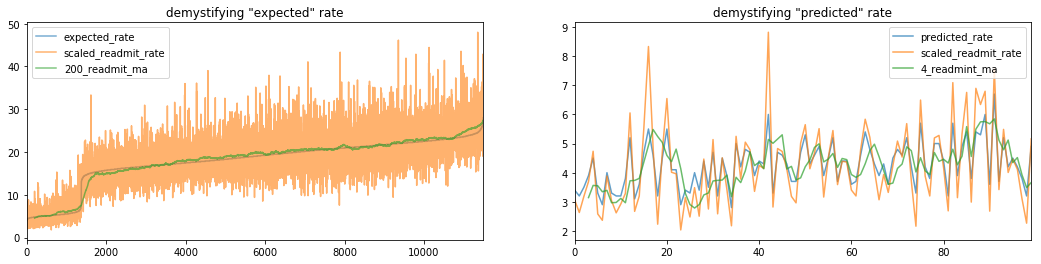

In [9]:
fig4()

The excess ratio is a normal distribution with a mean value at roughly 1. Given that this ratio can be approximated by a fast oscillator divided by a slow oscillator around a common value, this makes sense.

Smaller hospitals with < 300 discharges in the period (orange) have a slightly higher mean excess readmission ratio than larger hospitals (green). 

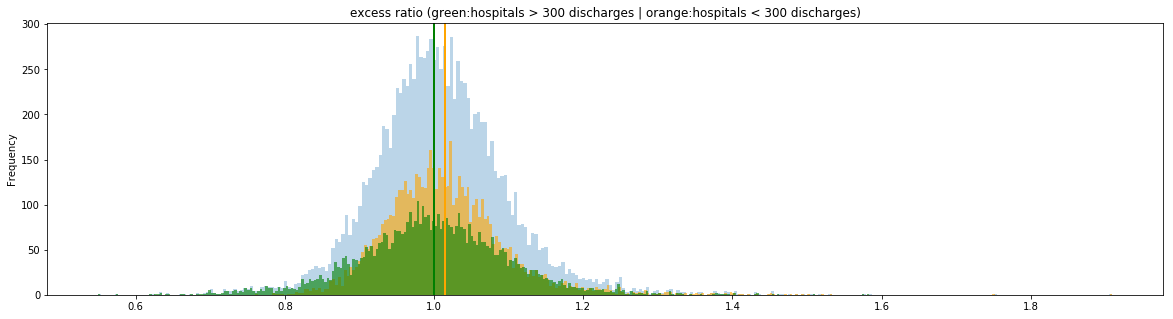

In [10]:
fig_excess_2()

<div  style="background-color:PapayaWhip"> <b> Hospital Readmission - conclusion </b></div>

Plotting the excess ratio against the readmission rate (below left), once again the elite hospitals show up clearly.  This plot reminds us that the excess ratio is a peer group measurement.  A high excess ratio value does not necessarily indicate a bad hospital, only one that is performing poorly compared to its immediate peers.  Thus, some of the highest excess ratio values belong to some of the better hospitals with readmission rates in the neighborhood of 10%.  

Remembering that, among hospitals with discharges greater than 300, a readmission rate at 10% almost never happens (because the distribution is strongly bimodal beyond that point), it becomes clear these hospitals with high excess ratio values but good overall readmission rates near 10% must be smaller hospitals.

In contrast, the worst performing hospitals, with readmission rates > 30%, nearly all have an excess ratio just above 1.  This is because, although these hospitals are death traps, their peers are also death traps. 

In other words, the excess ratio is close to useless as a way to separate hospitals by performance, although it correlates well with readmission rates once that separation has been made, as in the lower left plot.

This must inform how we interpret the plot on the lower right, which is the only plot the study itself includes. With an R value between the excess ratio and discharges of nearly -.1, there's a barely-there correlation between the excess_ratio and hospital size.  But with a p-value that is far below .1, the level of confidence that that correlation exists is very high.

In a sense, this is a more significant result than it seems to be.  Size, as we can see by comparing the two plots below, is poorly aligned with the peer groups that are used to generate the excess ratio, so much so that one might reasonably expect there to be no trend between discharges and the excess ratio at all.  Yet there is one.  

The interpretation suggested by the excess ratio in relation to hospital size would be that, as hospital size grows, there is a very slight but very reliable tendency for hospitals to underperform their peers less. In other words, the bigger hospitals get, the more their performance is like that of their peers.  This is exactly what we saw in the scatter plot of readmission rates against discharges above, in which hospitals were more likely to have performance near the mean values of the two performance groups as size increased.

                                                          r: -0.0930955428759  | p: 1.50227564265e-23


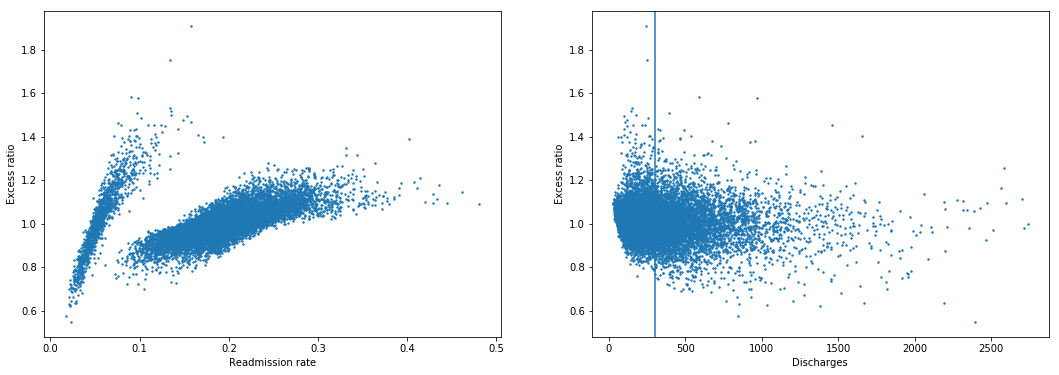

In [11]:
fig_excess_1()
ccdd = cdf[cdf.discharges < 3000]  # ditch a few outliers

r_row, p_value = scipy.stats.pearsonr(ccdd.excess_ratio, ccdd.discharges)
print '                                                          r:',r_row, ' | p:',p_value


# just trying another method
#slope, intercept, r_value, p_value, std_err = stats.linregress(ccdd.excess_ratio,ccdd.discharges)
#print slope, intercept, r_value, p_value, std_err